<a href="https://colab.research.google.com/github/carlosmatherson/PolymerGCN/blob/main/TgGCN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Setup


Install Spektral and RDKit.

In [ ]:
!pip install spektral
!pip install rdkit

Import necessary packages and functions.

In [ ]:
# general tools
import numpy as np
import pandas as pd
import colour

# RDkit
from rdkit import Chem
from rdkit.Chem.rdmolops import GetAdjacencyMatrix

# Spektral
from spektral.utils.sparse import reorder
from spektral.data.graph import Graph
from spektral.data import Dataset, BatchLoader
from spektral.layers import GCNConv, GlobalSumPool

# TensorFlow & Keras
from tensorflow.keras.layers import Dense
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import RootMeanSquaredError

# Matplotlib
import matplotlib.pyplot as plt

# Featurization

Onehot Encoding: Maps input elements x which are not in the permitted list to the last element of the permitted list.

In [ ]:
# Onehot Encoding
def one_hot_encoding(x, permitted_list):

    if x not in permitted_list:
        x = permitted_list[-1]

    binary_encoding = [int(boolean_value) for boolean_value in list(map(lambda s: x == s, permitted_list))]

    return binary_encoding

Atom Featurization: Takes an RDKit atom object as input and gives a 1d-numpy array of atom features as output.

In [ ]:
# Atom Featurization
def get_atom_features(atom, 
                      use_chirality = True, 
                      hydrogens_implicit = True):

    # define list of permitted atoms
    
    permitted_list_of_atoms =  ['C','N','O','S','F','Si','P','Cl','Br','Mg','Na','Ca','Fe','As','Al','I', 'B','V','K','Tl','Yb','Sb','Sn','Ag','Pd','Co','Se','Ti','Zn', 'Li','Ge','Cu','Au','Ni','Cd','In','Mn','Zr','Cr','Pt','Hg','Pb','Unknown']
    
    if hydrogens_implicit == False:
        permitted_list_of_atoms = ['H'] + permitted_list_of_atoms
    
    # compute atom features
    
    atom_type_enc = one_hot_encoding(str(atom.GetSymbol()), permitted_list_of_atoms)
    
    n_heavy_neighbors_enc = one_hot_encoding(int(atom.GetDegree()), [0, 1, 2, 3, 4, "MoreThanFour"])
    
    formal_charge_enc = one_hot_encoding(int(atom.GetFormalCharge()), [-3, -2, -1, 0, 1, 2, 3, "Extreme"])
    
    hybridisation_type_enc = one_hot_encoding(str(atom.GetHybridization()), ["S", "SP", "SP2", "SP3", "SP3D", "SP3D2", "OTHER"])
    
    is_in_a_ring_enc = [int(atom.IsInRing())]
    
    is_aromatic_enc = [int(atom.GetIsAromatic())]
    
    atomic_mass_scaled = [float((atom.GetMass() - 10.812)/116.092)]
    
    vdw_radius_scaled = [float((Chem.GetPeriodicTable().GetRvdw(atom.GetAtomicNum()) - 1.5)/0.6)]
    
    covalent_radius_scaled = [float((Chem.GetPeriodicTable().GetRcovalent(atom.GetAtomicNum()) - 0.64)/0.76)]

    atom_feature_vector = atom_type_enc + n_heavy_neighbors_enc + formal_charge_enc + hybridisation_type_enc + is_in_a_ring_enc + is_aromatic_enc + atomic_mass_scaled + vdw_radius_scaled + covalent_radius_scaled
                                    
    if use_chirality == True:
        chirality_type_enc = one_hot_encoding(str(atom.GetChiralTag()), ["CHI_UNSPECIFIED", "CHI_TETRAHEDRAL_CW", "CHI_TETRAHEDRAL_CCW", "CHI_OTHER"])
        atom_feature_vector += chirality_type_enc
    
    if hydrogens_implicit == True:
        n_hydrogens_enc = one_hot_encoding(int(atom.GetTotalNumHs()), [0, 1, 2, 3, 4, "MoreThanFour"])
        atom_feature_vector += n_hydrogens_enc

    return np.array(atom_feature_vector)

Bond Featurization: Takes an RDKit bond object as input and gives a 1d-numpy array of bond features as output.

In [ ]:
# Bond Featurisation
def get_bond_features(bond, 
                      use_stereochemistry = True):

    permitted_list_of_bond_types = [Chem.rdchem.BondType.SINGLE, Chem.rdchem.BondType.DOUBLE, Chem.rdchem.BondType.TRIPLE, Chem.rdchem.BondType.AROMATIC]

    bond_type_enc = one_hot_encoding(bond.GetBondType(), permitted_list_of_bond_types)
    
    bond_is_conj_enc = [int(bond.GetIsConjugated())]
    
    bond_is_in_ring_enc = [int(bond.IsInRing())]
    
    bond_feature_vector = bond_type_enc + bond_is_conj_enc + bond_is_in_ring_enc
    
    if use_stereochemistry == True:
        stereo_type_enc = one_hot_encoding(str(bond.GetStereo()), ["STEREOZ", "STEREOE", "STEREOANY", "STEREONONE"])
        bond_feature_vector += stereo_type_enc

    return np.array(bond_feature_vector)

Dablander, Markus. How to Turn a SMILES String into a Molecular Graph for Pytorch Geometric | Oxford Protein Informatics Group. https://www.blopig.com/blog/2022/02/how-to-turn-a-smiles-string-into-a-molecular-graph-for-pytorch-geometric/. Accessed 11 July 2022.


# Create Dataset

Subclass the Dataset class to standardize how graph datasets are represented in Spektral. Here, you can choose the endpoint to work with.

In [ ]:
class MyDataset(Dataset):
  def read(self):
    global polydata
    polydata = pd.read_csv("https://raw.githubusercontent.com/carlosmatherson/SULI-Project/main/SMILES_Density_Tg_Mt.csv") #"Tg"
    #polydata = pd.read_csv("https://raw.githubusercontent.com/liugangcode/GREA/main/data/tg_prop/raw/tg_raw.csv") # "tg"
    graph_list = makeGraphObjList(polydata["SMILES"], polydata["Tg"]) 
    return graph_list

Define `makeGraphObjList` to create Spektral graph dataset from smiles and labels. The function takes a list of SMILES strings `x_smiles = [smiles_1, smiles_2, ....]` and a list of numerial labels for the SMILES strings `y = [y_1, y_2, ...]` as inputs. The output is a list of spektral.data.graph.Graph objects that can readily be used for machine learning, `graph_list = [G_1, G_2, ...]`. 






In [ ]:
def makeGraphObjList(x_smiles, y):
    
    graph_list = []

    for (smiles, y_val) in zip(x_smiles, y):
        
        # convert SMILES to RDKit mol object
        mol = Chem.MolFromSmiles(smiles)
        
        # get feature dimensions
        n_nodes = mol.GetNumAtoms()
        n_edges = 2*mol.GetNumBonds()
        unrelated_smiles = "O=O"
        unrelated_mol = Chem.MolFromSmiles(unrelated_smiles)
        n_node_features = len(get_atom_features(unrelated_mol.GetAtomWithIdx(0)))
        n_edge_features = len(get_bond_features(unrelated_mol.GetBondBetweenAtoms(0,1)))

        # construct adjacency matrix (n_nodes, n_nodes), full matrix
        A = np.array(GetAdjacencyMatrix(mol)) # full matrix

        # construct edge index array Ei of shape (n_edges, 2), sparse matrix
        Ei = np.transpose(np.nonzero(A)) # vertical format
        (rows, cols) = np.transpose(Ei)

        # construct node feature matrix Xn of shape (n_nodes, n_node_features)
        X = np.zeros((n_nodes, n_node_features))
        for atom in mol.GetAtoms():
            X[atom.GetIdx(), :] = get_atom_features(atom)
        
        # construct edge feature array Ef of shape (n_edges, n_edge_features)
        E = np.zeros((n_edges, n_edge_features))
        for (k, (i,j)) in enumerate(zip(rows, cols)):
            E[k] = get_bond_features(mol.GetBondBetweenAtoms(int(i),int(j)))
        reorder(Ei, E)
        
        # construct label tensor
        Y = np.array([y_val])

        # construct Spektral graph object and append to dataset (list)
        graph_list.append(Graph(x=X, a=A, e=E, y=Y))
        
    return graph_list 

# Graph Convolutional Network

Load data.

In [ ]:
data = MyDataset()  # store data in data
#gradient = polydata["Tg"]

Hyperparameters

In [ ]:
learning_rate = 1e-3                # Learning rate
epochs = 4000                          # Number of training epochs, 4000
batch_size = data.n_graphs          # Batch size 
train_split = 0.6                   # split %
optimizer = Adam(learning_rate)     # Optimizer
metrics = [RootMeanSquaredError()]  # metric
loss = 'mse'                        # Loss function

Split the dataset created above.

In [ ]:
lendata = int(len(data))
idxs = np.random.permutation(lendata)             # shuffle dataset
split = int(train_split * lendata)                # choose train split %
idx_tr, idx_te = np.split(idxs, [split])            # sort tr/te indices 
dataset_tr, dataset_te = data[idx_tr], data[idx_te] # store train / test data

GCN body: 6 layers, 100 nodes each, global pooling, no masking

NN body: 2 layers, 300 nodes each, output layer

In [ ]:
#model
class myGCN(Model):

    def __init__(self):
      super().__init__()
      self.conv1 = GCNConv(100, activation="relu")    # 6 convolutional layers
      self.conv2 = GCNConv(100, activation="relu")
      self.conv3 = GCNConv(100, activation="relu")
      self.conv4 = GCNConv(100, activation="relu")
      self.conv5 = GCNConv(100, activation="relu")
      self.conv6 = GCNConv(100, activation="relu")  
      self.global_pool = GlobalSumPool()              # global sum
      self.mlp1 = Dense(units=300, activation="relu") # 2 hidden layers
      self.mlp2 = Dense(units=300, activation="relu")
      self.dense = Dense(data.n_labels)               # output       

    def call(self, inputs):
      global x, a, gcn_out, nn_out
      x, a = inputs[0], inputs[1]
      x = self.conv1([x, a])
      x = self.conv2([x, a])
      x = self.conv3([x, a])
      x = self.conv4([x, a])
      x = self.conv5([x, a])
      x = self.conv6([x, a])
      x = self.global_pool(x)
      gcn_out = self.dense(x)
      x = self.mlp1(x)
      x = self.mlp2(x)
      nn_out = self.dense(x)

      return gcn_out, nn_out # return loss and metric for GCN and NN layers
        
model = myGCN()

Compile model & choose loss

In [ ]:
model.compile(optimizer=optimizer, metrics=metrics, loss=loss, run_eagerly=True)

Load training data as batch (zero-padded with masking) and train the model

In [ ]:
loader_tr = BatchLoader(dataset_tr, batch_size=batch_size, mask=True)
history = model.fit(loader_tr.load(), steps_per_epoch=loader_tr.steps_per_epoch, epochs=epochs)

Load testing data as batch (zero-padded with masking) and evaluate the model

In [ ]:
print("Testing model")
loader_te = BatchLoader(dataset_te, batch_size=batch_size, mask=True)
loss = model.evaluate(loader_te.load(), steps=loader_te.steps_per_epoch)
print("Done. Test loss: \tMSE \t\t  GCN MSE \t NN MSE \t GCN RMSE \t\t NN RMSE \n \t\t{}".format(loss))

Testing model


/usr/local/lib/python3.7/dist-packages/spektral/data/utils.py:221: UserWarning: you are shuffling a 'MyDataset' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
  np.random.shuffle(a)
/usr/local/lib/python3.7/dist-packages/spektral/layers/convolutional/conv.py:94: UserWarning: The adjacency matrix of dtype <dtype: 'int32'> is incompatible with the dtype of the node features <dtype: 'float32'> and has been automatically cast to <dtype: 'float32'>.
  f"The adjacency matrix of dtype {a.dtype} is incompatible with the dtype "


1/1 [==============================] - 0s 362ms/step - loss: 4965.0381 - output_1_loss: 2638.0618 - output_2_loss: 2326.9761 - output_1_root_mean_squared_error: 51.3621 - output_2_root_mean_squared_error: 48.2387
Done. Test loss: 	MSE 		  GCN MSE 	 NN MSE 	 GCN RMSE 		 NN RMSE 
 		[4965.0380859375, 2638.061767578125, 2326.97607421875, 51.36206817626953, 48.238739013671875]


# Visualization (future work)

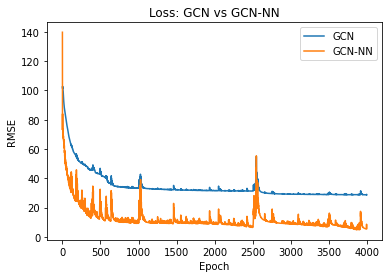

In [ ]:
fig, ax = plt.subplots()
plt.plot(history.history['output_1_root_mean_squared_error'], label="GCN")
plt.plot(history.history['output_2_root_mean_squared_error'], label="GCN-NN")
plt.title("Loss: GCN vs GCN-NN")
plt.xlabel("Epoch")
plt.ylabel("RMSE")
ax.legend()
plt.show()

No handles with labels found to put in legend.


[9.9820447e-01 5.1622768e-04]


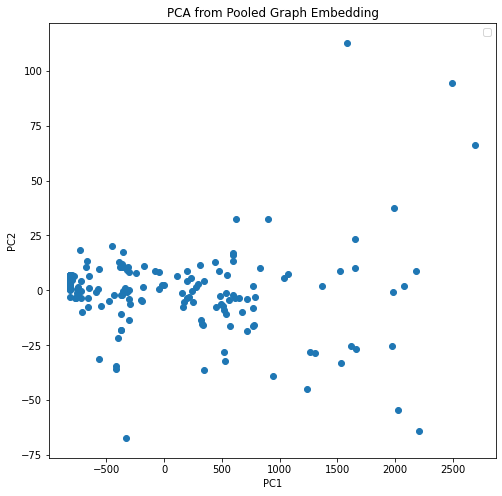

In [ ]:
from sklearn.decomposition import PCA
from matplotlib.colors import Normalize

# Create a 2D PCA projection of the embeddings
GCNrepresentation = gcn_out.numpy()
pca = PCA(n_components=2)
pca.fit(GCNrepresentation)
pca_gcn = pca.transform(GCNrepresentation)
print(pca.explained_variance_ratio_)

# Plot those points as a scatter plot 
fig, ax = plt.subplots(figsize=(8,8))
num_categories = data.n_labels
plt.title("PCA from Pooled Graph Embedding")
plt.xlabel("PC1")
plt.ylabel("PC2")
ax.legend()
ax.scatter(pca_gcn[:,0],pca_gcn[:,1]) # c=np.array(cmap(lab)).reshape(1,4)
plt.show()